## VC_2_Lab_15_Fingerprint_Recognition.ipynb

Neste jupyter vamos fazer tentar criar uma Autoencoder para Fingerprint.

**[Autoencoders](https://en.wikipedia.org/wiki/Autoencoder#Image_Processing)** são redes neurais treinadas com o objetivo de copiar o seu input para o seu output. Esse interesse pode parecer meio estranho, mas na prática o objetivo é aprender representações (encodings) dos dados. Na área de processamento de imagens são utilizados para remover ruído de imagens (denoising) e super-resolução.

Este jupyter notebook deve ser executado no Google Colab (https://colab.research.google.com/) devendo o aluno carregar as imagens que estão compactadas no ZIP **Laboratório/fingerprint.zip** na pasta **VC_1/face_recognition/** dentro do seu Google Drive

### Visão Computacional 2

### Prof: José Humberto Cruvinel

Este jupyter notebook deve ser executado no Google Colab (https://colab.research.google.com/) 

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Entrando no diretório
%cd /content/drive/MyDrive/Colab Notebooks/fingerprint

/content/drive/MyDrive/Colab Notebooks/fingerprint


In [ ]:
# Listando o conteúdo

%ls -la

total 16
drwx------ 2 root root 4096 Nov 21 18:44 DB1_B/
drwx------ 2 root root 4096 Nov 21 18:44 DB2_B/
drwx------ 2 root root 4096 Nov 21 18:44 DB3_B/
drwx------ 2 root root 4096 Nov 21 18:44 DB4_B/


In [ ]:
# Imports 
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage.filters import threshold_otsu
from glob import glob
from matplotlib.patches import Circle,Ellipse
from matplotlib.patches import Rectangle
from PIL import Image
from matplotlib import pyplot as plt
import numpy as np
import keras
from keras.layers import Input,Conv2D,MaxPooling2D,UpSampling2D
from keras.models import Model
from keras.optimizers import RMSprop
from keras.layers.normalization import BatchNormalization
%matplotlib inline

In [ ]:
%%time
# Carregando o conjunto de dados
data = glob('DB*/*')
images = []
def readImages(data):
    for i in range(len(data)):
        if i%100 == 0:
          print('Processados:',i)
        img = Image.open(data[i])
        img = img.resize((224,224))
        images.append(np.asarray(img))
    return images
images = readImages(data)

Processados: 0
Processados: 100
Processados: 200
Processados: 300
CPU times: user 514 ms, sys: 98.2 ms, total: 612 ms
Wall time: 895 ms


In [ ]:
# Convertendo as imagens para array
images_arr = np.asarray(images)
images_arr = images_arr.astype('float32')
print("Dataset (images) shape: {}".format(images_arr.shape))

Dataset (images) shape: (320, 224, 224)


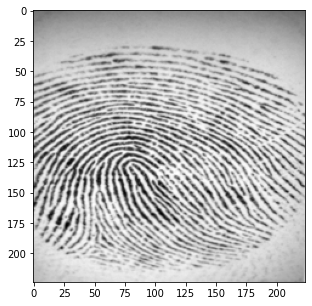

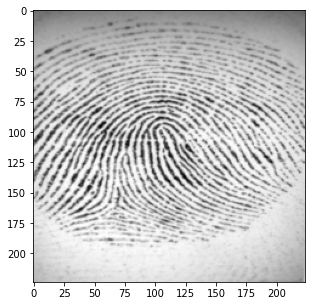

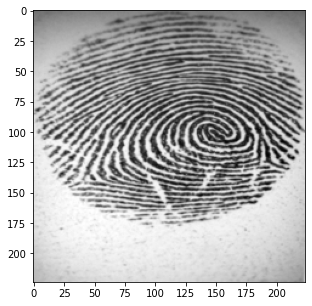

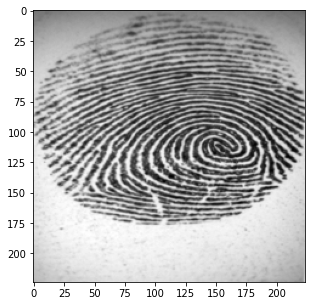

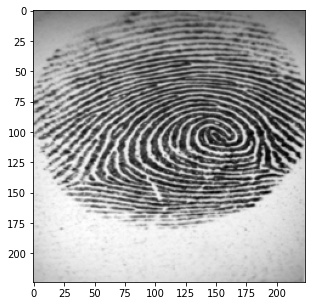

In [ ]:
# Mostrando as primeiras 5 imagens
for i in range(5):
    plt.figure(figsize=[5, 5])
    curr_img = np.reshape(images_arr[i], (224,224))
    plt.imshow(curr_img, cmap='gray')
    plt.show()

In [ ]:
images_arr = images_arr.reshape(-1, 224,224, 1)
print('Shape:',images_arr.shape)
print('Dtype:',images_arr.dtype)

Shape: (320, 224, 224, 1)
Dtype: float32


In [ ]:
# Normalização, os valores devem ficar entre 0 e 1
np.max(images_arr)
images_arr = images_arr / np.max(images_arr)
print('Max:',np.max(images_arr))
print('Min:',np.min(images_arr))

Max: 1.0
Min: 0.0


Antes: (320, 224, 224, 1)
Depois: (640, 224, 224, 1)


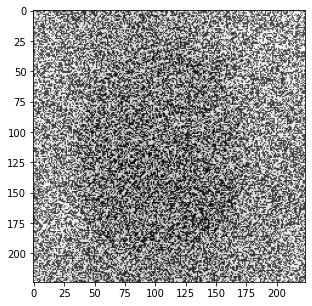

In [ ]:
# Adicionando ruído nos dados
print(f'Antes: {images_arr.shape}')

noise = np.random.randint(0, 2, (len(images_arr), 224, 224, 1))
images_arr_mod = images_arr + noise
images_arr = np.concatenate((images_arr_mod, images_arr))
print(f'Depois: {images_arr.shape}')

plt.figure(figsize=[5, 5])
curr_img = np.reshape(images_arr_mod[200], (224,224))
plt.imshow(curr_img, cmap='gray')
plt.show()

In [ ]:
# Como queremos criar um autoencoder, vamos passar o dataset duas vezes
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(images_arr, images_arr, test_size=0.2, random_state=13)

In [ ]:
print(f'Shape X_train com ruído: {len(X_train)}')
print(f'Shape X_test com ruído: {len(X_test)}')

Shape X_train com ruído: 512
Shape X_test com ruído: 128


In [ ]:
BATCH_SIZE = 128
EPOCHS = 1000 
x, y = 224, 224
input_img = Input(shape = (x, y, 1))

In [ ]:
# Criação da rede neural
def autoencoder(input_img):
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img) #28 x 28 x 32
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1) #14 x 14 x 32
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1) #14 x 14 x 64
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2) #7 x 7 x 64
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool2) #7 x 7 x 128 (small and thick)#decoder
    conv4 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv3) #7 x 7 x 128
    up1 = UpSampling2D((2,2))(conv4) # 14 x 14 x 128
    conv5 = Conv2D(64, (3, 3), activation='relu', padding='same')(up1) # 14 x 14 x 64
    up2 = UpSampling2D((2,2))(conv5) # 28 x 28 x 64
    decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(up2) # 28 x 28 x 1
    return decoded
autoencoder = Model(input_img, autoencoder(input_img))
autoencoder.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 1)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 224, 224, 32)      320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 112, 112, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 112, 112, 64)      18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 56, 56, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 56, 56, 128)       73856     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 56, 56, 128)      

In [ ]:
# Compilando o modelo
autoencoder.compile(loss='mean_squared_error', optimizer = RMSprop(), metrics='accuracy')

In [ ]:
# Treinamento
autoencoder_train = autoencoder.fit(
    X_train, y_train, 
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    verbose=1,
    validation_data=(X_test, y_test))

Epoch 1/1000
4/4 [==============================] - 2s 507ms/step - loss: 0.2543 - accuracy: 0.0157 - val_loss: 0.2133 - val_accuracy: 0.0152
Epoch 2/1000
4/4 [==============================] - 2s 581ms/step - loss: 0.1968 - accuracy: 0.0157 - val_loss: 0.2404 - val_accuracy: 0.0152
Epoch 3/1000
4/4 [==============================] - 2s 580ms/step - loss: 0.1969 - accuracy: 0.0157 - val_loss: 0.2053 - val_accuracy: 0.0152
Epoch 4/1000
4/4 [==============================] - 2s 584ms/step - loss: 0.1934 - accuracy: 0.0157 - val_loss: 0.2271 - val_accuracy: 0.0152
Epoch 5/1000
4/4 [==============================] - 2s 585ms/step - loss: 0.1893 - accuracy: 0.0158 - val_loss: 0.1976 - val_accuracy: 0.0153
Epoch 6/1000
4/4 [==============================] - 2s 591ms/step - loss: 0.1954 - accuracy: 0.0156 - val_loss: 0.2435 - val_accuracy: 0.0153
Epoch 7/1000
4/4 [==============================] - 2s 586ms/step - loss: 0.1907 - accuracy: 0.0158 - val_loss: 0.1939 - val_accuracy: 0.0154
Epoch 

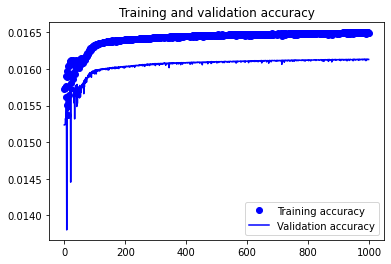

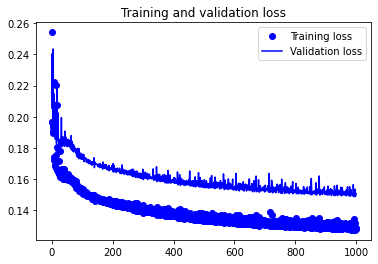

In [ ]:
# Plotando os resultados
accuracy = autoencoder_train.history['accuracy']
val_accuracy = autoencoder_train.history['val_accuracy']
epochs = range(EPOCHS)
plt.figure()
plt.plot(epochs, accuracy, 'bo', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.show()

loss = autoencoder_train.history['loss']
val_loss = autoencoder_train.history['val_loss']
epochs = range(EPOCHS)
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [ ]:
# Prevendo os dados de teste
pred = autoencoder.predict(X_test)

Imagens de teste


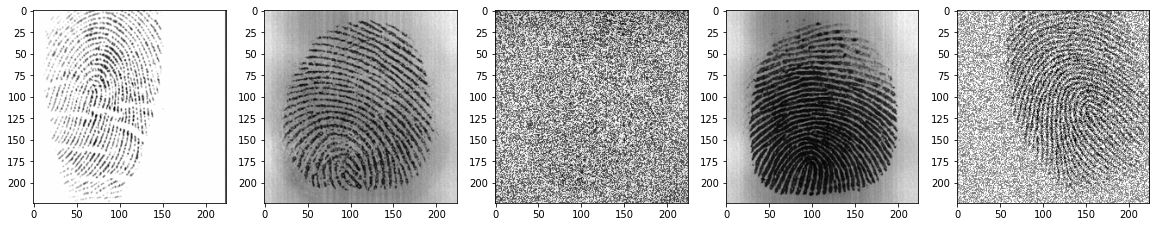

Reconstrução com o Autoencoder


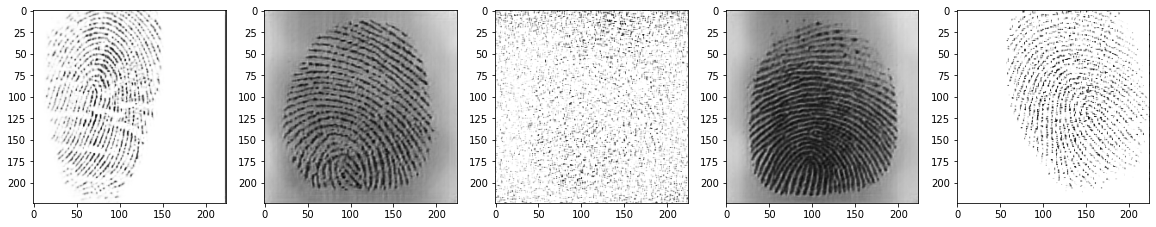

In [ ]:
# Plotando algumas imagens
plt.figure(figsize=(20, 4))
print("Imagens de teste")
for i in range(5):
    plt.subplot(1, 5, i+1)
    plt.imshow(y_test[i, ..., 0], cmap='gray')
plt.show()    
plt.figure(figsize=(20, 4))
print("Reconstrução com o Autoencoder")
for i in range(5):
    plt.subplot(1, 5, i+1)
    plt.imshow(pred[i, ..., 0], cmap='gray')  
plt.show()

# Exercício 15.1

Veja que o nosso autoecoder ainda não está bom. 

Aumente a quantidade de passos de treinamento para tentar melhorar. Lembre de ativar o uso de GPU.

Após obter um bom autoencoder, escolha algumas imagens de teste, adicione um ruído nessa imagem e submeta ao autoencoder e veja o resultado, comparando a imagem resultante com a original sem ruído.

Duplique as imagens de entrada, aplicando no segundo grupo algum tipo de ruído e treine novamente e veja os resultados.

FIM